In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os.path, sys, re
from scipy.fft import fft, fftfreq

In [2]:
#Mount Google Drive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [3]:
def img_viewer(image_file_name,lead_dict,threshold):

    """
    This function loads the file specified in "image_file".
    It then plots the lead specified, and its fit
    """

    img_arr=cv2.imread(image_file_name)


    # These are the image limits in the array for each of the leads
    xlow = lead_dict["xlow"]
    xhigh = lead_dict["xhigh"]
    ylow = lead_dict["ylow"]
    yhigh = lead_dict["yhigh"]

    # this is the baseline of the lead
    baseline = lead_dict["baseline"]


    # read the image
    lead_arr = ((cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)[ylow:yhigh,xlow:xhigh][::-1,:].transpose() ))#).astype("int")
    lead_arr = lead_arr < threshold

    # average the location of the y value based on the number of "on = 1" pixel at each x value
    ysums = np.sum(lead_arr,axis=1)
    # array of indices with length of the y-axis, for each x-index
    indmat = ((np.arange(lead_arr.shape[1]))*np.ones(lead_arr.shape[0]).reshape(-1,1))

    # perform the average, and subtract the baseline
    # note that this can result in NaN for columns with 0 pixels on.
    # we take care of that later
    # here, we do not subtract the baseline, but rather plot it
    series_vals = np.sum(lead_arr*indmat,axis=1) / ysums #- baseline

    #fill in blanks using pd.series.fillna
    series_vals = pd.Series(series_vals)
    series_vals.fillna(method="ffill",inplace=True)
    series_vals.fillna(method="bfill",inplace=True)
    series_vals = series_vals.to_numpy()


    avg = np.mean(series_vals[(series_vals!=0) & (np.logical_not(np.isnan(series_vals))) ])
    print(avg)

    # plot the results
    plt.figure(figsize=(24,15))
    plt.scatter(np.arange(len(series_vals)),series_vals)
    plt.plot(np.arange(len(series_vals)),series_vals,"-r")
    plt.imshow(lead_arr.transpose(),cmap="gray",origin="lower")
#    plt.plot(np.arange(len(series_vals)),baseline*np.ones(len(series_vals)),"-y")

    plt.plot(np.arange(len(series_vals)),avg*np.ones(len(series_vals)),"-w")

    print(len(series_vals))


In [4]:
def read_leads(image_file_name,lead_dict,threshold):
    """
    This function loads the file specified in "image_file".
    The 13 coordinates in lead_dicts are used to sparate the image into 13 separate images.
    The function applies a mask to each image, and returns a 1D numpy array for each sub-image.
    Each 1D array contains the average coordinates of the ECG lead.
    """

    img_arr=cv2.imread(image_file_name)

    all_leads = np.array([])


    for lead in lead_dict:

        # These are the image limits in the array for each of the leads
        xlow = lead_dict[lead]["xlow"]
        xhigh = lead_dict[lead]["xhigh"]
        ylow = lead_dict[lead]["ylow"]
        yhigh = lead_dict[lead]["yhigh"]

        # this is the baseline of the lead
        baseline = lead_dict[lead]["baseline"]


        # read the image
        lead_arr = ((cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)[ylow:yhigh,xlow:xhigh][::-1,:].transpose() ))#).astype("int")
        lead_arr = lead_arr < threshold

        # average the location of the y value based on the number of "on = 1" pixel at each x value
        ysums = np.sum(lead_arr,axis=1)
        # array of indices with length of the y-axis, for each x-index
        indmat = ((np.arange(lead_arr.shape[1]))*np.ones(lead_arr.shape[0]).reshape(-1,1))

        # perform the average, and subtract the baseline
        # note that this can result in NaN for columns with 0 pixels on.

#        series_vals = np.sum(lead_arr*indmat,axis=1) / ysums - baseline

        # alternatively average all y-values and use the result as the baseline
        series_vals = np.sum(lead_arr*indmat,axis=1) / ysums

        #fill in blanks using pd.series.fillna
        series_vals = pd.Series(series_vals)
        series_vals.fillna(method="ffill",inplace=True)
        series_vals.fillna(method="bfill",inplace=True)
        series_vals = series_vals.to_numpy()

        avg = np.mean(series_vals[(series_vals!=0) & (np.logical_not(np.isnan(series_vals))) ])
        series_vals = series_vals - avg


        all_leads= np.concatenate((all_leads,series_vals))


    return all_leads

In [5]:
def read_leads_fft(image_file_name,lead_dict,threshold):
    """
    This function loads the file specified in "image_file".
    The 13 coordinates in lead_dicts are used to sparate the image into 13 separate images.
    The function applies a mask to each image, and returns a 1D numpy array for each sub-image.
    Each 1D array contains the average coordinates of the ECG lead.
    """

    img_arr=cv2.imread(image_file_name)

    all_leads = np.array([])


    for lead in lead_dict:

        # These are the image limits in the array for each of the leads
        xlow = lead_dict[lead]["xlow"]
        xhigh = lead_dict[lead]["xhigh"]
        ylow = lead_dict[lead]["ylow"]
        yhigh = lead_dict[lead]["yhigh"]

        # this is the baseline of the lead
        baseline = lead_dict[lead]["baseline"]


        # read the image
        lead_arr = ((cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)[ylow:yhigh,xlow:xhigh][::-1,:].transpose() ))#).astype("int")
        lead_arr = lead_arr < threshold

        # average the location of the y value based on the number of "on = 1" pixel at each x value
        ysums = np.sum(lead_arr,axis=1)
        # array of indices with length of the y-axis, for each x-index
        indmat = ((np.arange(lead_arr.shape[1]))*np.ones(lead_arr.shape[0]).reshape(-1,1))

        # perform the average, and subtract the baseline
        # note that this can result in NaN for columns with 0 pixels on.

#        series_vals = np.sum(lead_arr*indmat,axis=1) / ysums - baseline

        # alternatively average all y-values and use the result as the baseline
        series_vals = np.sum(lead_arr*indmat,axis=1) / ysums


        #fill in blanks using pd.series.fillna
        series_vals = pd.Series(series_vals)
        series_vals.fillna(method="ffill",inplace=True)
        series_vals.fillna(method="bfill",inplace=True)
        series_vals = series_vals.to_numpy()


        avg = np.mean(series_vals[(series_vals!=0) & (np.logical_not(np.isnan(series_vals))) ])
        series_vals = series_vals - avg

        series_vals = np.abs(fft(series_vals))

        all_leads= np.concatenate((all_leads,series_vals))


    return all_leads

In [6]:
# This is the dictionary for the leads in the regular format.
# The baseline input is not used at the moment. Instead, the average pixel height is used.

lead_dict_format1 = {"lead_I":{"ylow":360,"yhigh":560,"xlow":180,"xhigh":640,"baseline":96},
                    "lead_II":{"ylow":660,"yhigh":860,"xlow":180,"xhigh":640,"baseline":96},
                    "lead_III":{"ylow":960,"yhigh":1160,"xlow":180,"xhigh":640,"baseline":93},
                    "lead_aVR":{"ylow":360,"yhigh":560,"xlow":700,"xhigh":1130,"baseline":96},
                    "lead_aVL":{"ylow":660,"yhigh":860,"xlow":700,"xhigh":1130,"baseline":96},
                    "lead_aVF":{"ylow":960,"yhigh":1160,"xlow":700,"xhigh":1130,"baseline":93},
                    "lead_V1":{"ylow":360,"yhigh":560,"xlow":1170,"xhigh":1620,"baseline":96},
                    "lead_V2":{"ylow":660,"yhigh":860,"xlow":1170,"xhigh":1620,"baseline":96},
                    "lead_V3":{"ylow":960,"yhigh":1160,"xlow":1170,"xhigh":1620,"baseline":93},

                    "lead_V4":{"ylow":360,"yhigh":560,"xlow":1660,"xhigh":2120,"baseline":96},
                    "lead_V5":{"ylow":660,"yhigh":860,"xlow":1660,"xhigh":2120,"baseline":96},
                    "lead_V6":{"ylow":960,"yhigh":1160,"xlow":1660,"xhigh":2120,"baseline":93},
                    "lead_long":{"ylow":1260,"yhigh":1460,"xlow":180,"xhigh":2120,"baseline":93},
                   }

# The threshold for filtering noise and the milimetric sheet grid in the regular format
threshold_format1 = 30

In [7]:
2120-180

1940

In [8]:
# The list of directories for the 5 different ECG categories
data_dirs = ["/drive/MyDrive/ECG/data_v1/"]

path_NormalPersonECGImages = "NormalPersonECGImages/"
path_ECGImagesofPatientthathaveabnormalheartbeats = "ECGImagesofPatientthathaveabnormalheartbeats/"
path_ECGImagesofPatientthathaveHistoryofMI = "ECGImagesofPatientthathaveHistoryofMI/"
path_ECGImagesofMyocardialInfarctionPatients = "ECGImagesofMyocardialInfarctionPatients/"


In [9]:
[(i,j,i+j) for i in range(1,3) for j in range(i,5)]

[(1, 1, 2), (1, 2, 3), (1, 3, 4), (1, 4, 5), (2, 2, 4), (2, 3, 5), (2, 4, 6)]

In [10]:
# This function accepts a list of ECG image file paths and reutrns the feature array of all leads for each image
def get_results(path_list):
    results = []
    for file_name in path_list:
        results.append(read_leads(file_name,lead_dict_format1,threshold_format1) )
    results = (np.column_stack(results)).transpose()

    return results

In [11]:
# This function accepts a list of ECG image file paths and reutrns the feature array of all leads for each image
def get_results_fft(path_list):
    results = []
    for file_name in path_list:
        results.append(read_leads_fft(file_name,lead_dict_format1,threshold_format1) )
    results = (np.column_stack(results)).transpose()

    return results

In [12]:
NormalPersonECGImages1 = sorted(
    [data_dirs[0] +path_NormalPersonECGImages+file for file in os.listdir(data_dirs[0] + path_NormalPersonECGImages)]

)

In [13]:
ECGImagesofPatientthathaveabnormalheartbeats1 = sorted(
#         [data_dirs[0] + path_ECGImagesofPatientthathaveabnormalheartbeats+file
#         for file in os.listdir(data_dirs[0] + path_ECGImagesofPatientthathaveabnormalheartbeats)
#         if int(file.replace("_",".").split(".")[1])<400]
#
#    +
    [data_dirs[0] + path_ECGImagesofPatientthathaveabnormalheartbeats+file
         for file in os.listdir(data_dirs[0] + path_ECGImagesofPatientthathaveabnormalheartbeats)]
)

In [14]:
ECGImagesofPatientthathaveHistoryofMI1 = sorted(
#    [data_dirs[0] + path_ECGImagesofPatientthathaveHistoryofMI+file
#    for file in os.listdir(data_dirs[0] + path_ECGImagesofPatientthathaveHistoryofMI)
#    if int(file.replace("_",".").split(".")[1])<113]

#+
    [data_dirs[0] + path_ECGImagesofPatientthathaveHistoryofMI+file
    for file in os.listdir(data_dirs[0] + path_ECGImagesofPatientthathaveHistoryofMI)]

)

In [15]:
ECGImagesofMyocardialInfarctionPatients1 = sorted(
#    [data_dirs[0] + path_ECGImagesofMyocardialInfarctionPatients+file
#    for file in os.listdir(data_dirs[0] + path_ECGImagesofMyocardialInfarctionPatients)
#    if int(file.replace("_",".").split(".")[1])<37]

#+
    [data_dirs[0] + path_ECGImagesofMyocardialInfarctionPatients+file
    for file in os.listdir(data_dirs[0] + path_ECGImagesofMyocardialInfarctionPatients)]


)

In [16]:
format1_categories = [NormalPersonECGImages1, ECGImagesofPatientthathaveabnormalheartbeats1,
                      ECGImagesofPatientthathaveHistoryofMI1,ECGImagesofMyocardialInfarctionPatients1]

In [17]:
# Number of samples in format1 for each category
print(
    len(NormalPersonECGImages1),
    len(ECGImagesofPatientthathaveabnormalheartbeats1),
    len(ECGImagesofPatientthathaveHistoryofMI1),
    len(ECGImagesofMyocardialInfarctionPatients1)
)

284 233 172 239


In [18]:
res_all = []
for category_ind, category in enumerate(format1_categories[:]):
    res = get_results(category)
    res = np.concatenate((res,category_ind*np.ones(res.shape[0]).reshape(-1,1)),axis=1)
    res_all.append(res)

<ipython-input-4-ab6aa5cb2011>:41: RuntimeWarning: invalid value encountered in divide
  series_vals = np.sum(lead_arr*indmat,axis=1) / ysums


In [19]:
res_all_fft = []
for category_ind, category in enumerate(format1_categories[:]):
    res = get_results_fft(category)
    res = np.concatenate((res,category_ind*np.ones(res.shape[0]).reshape(-1,1)),axis=1)
    res_all_fft.append(res)

<ipython-input-5-132e25ca231a>:41: RuntimeWarning: invalid value encountered in divide
  series_vals = np.sum(lead_arr*indmat,axis=1) / ysums


In [20]:
format1_dataset = np.concatenate(res_all)
format1_dataset_fft = np.concatenate(res_all_fft)

In [ ]:
pd.DataFrame(format1_dataset).to_csv("time_series_data.csv")

In [ ]:
pd.DataFrame(format1_dataset_fft).to_csv("time_series_data_fft.csv")

In [21]:
pd.DataFrame(format1_dataset).to_csv("time_series_data_v2.csv")
pd.DataFrame(format1_dataset_fft).to_csv("time_series_data_v2_fft.csv")

In [22]:
import shutil

# Define the paths of the CSV files
csv_file_path1 = "time_series_data_v2.csv"
csv_file_path2 = "time_series_data_v2_fft.csv"

# Define the destination folder on Google Drive
drive_folder_path = "/drive/MyDrive/ECG/"

# Copy the CSV files to the destination folder
shutil.copy(csv_file_path1, drive_folder_path)
shutil.copy(csv_file_path2, drive_folder_path)

print("CSV files copied to Google Drive ECG folder successfully.")


CSV files copied to Google Drive ECG folder successfully.


96.11574062585017
460


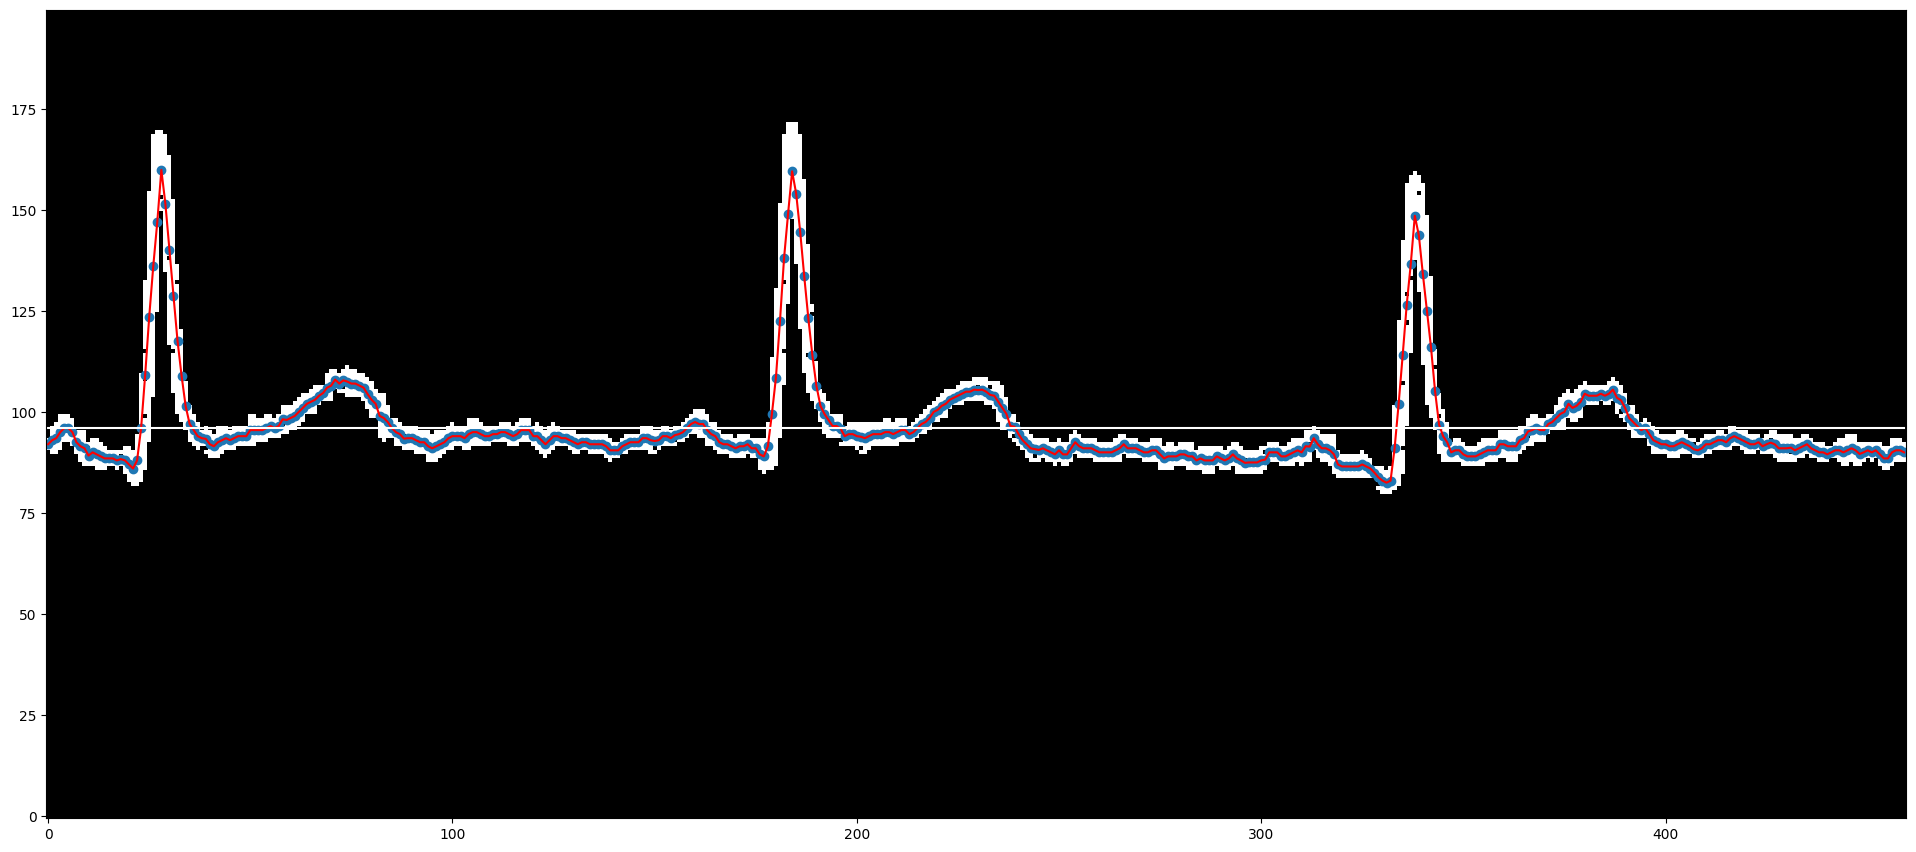

In [ ]:
# here you can plug in any ECG image file
img1 = img_viewer("/drive/MyDrive/ECG/data_v1/NormalPersonECGImages/Normal(5).jpg",
           lead_dict_format1["lead_I"],
           threshold_format1 )
plt.savefig("img1")

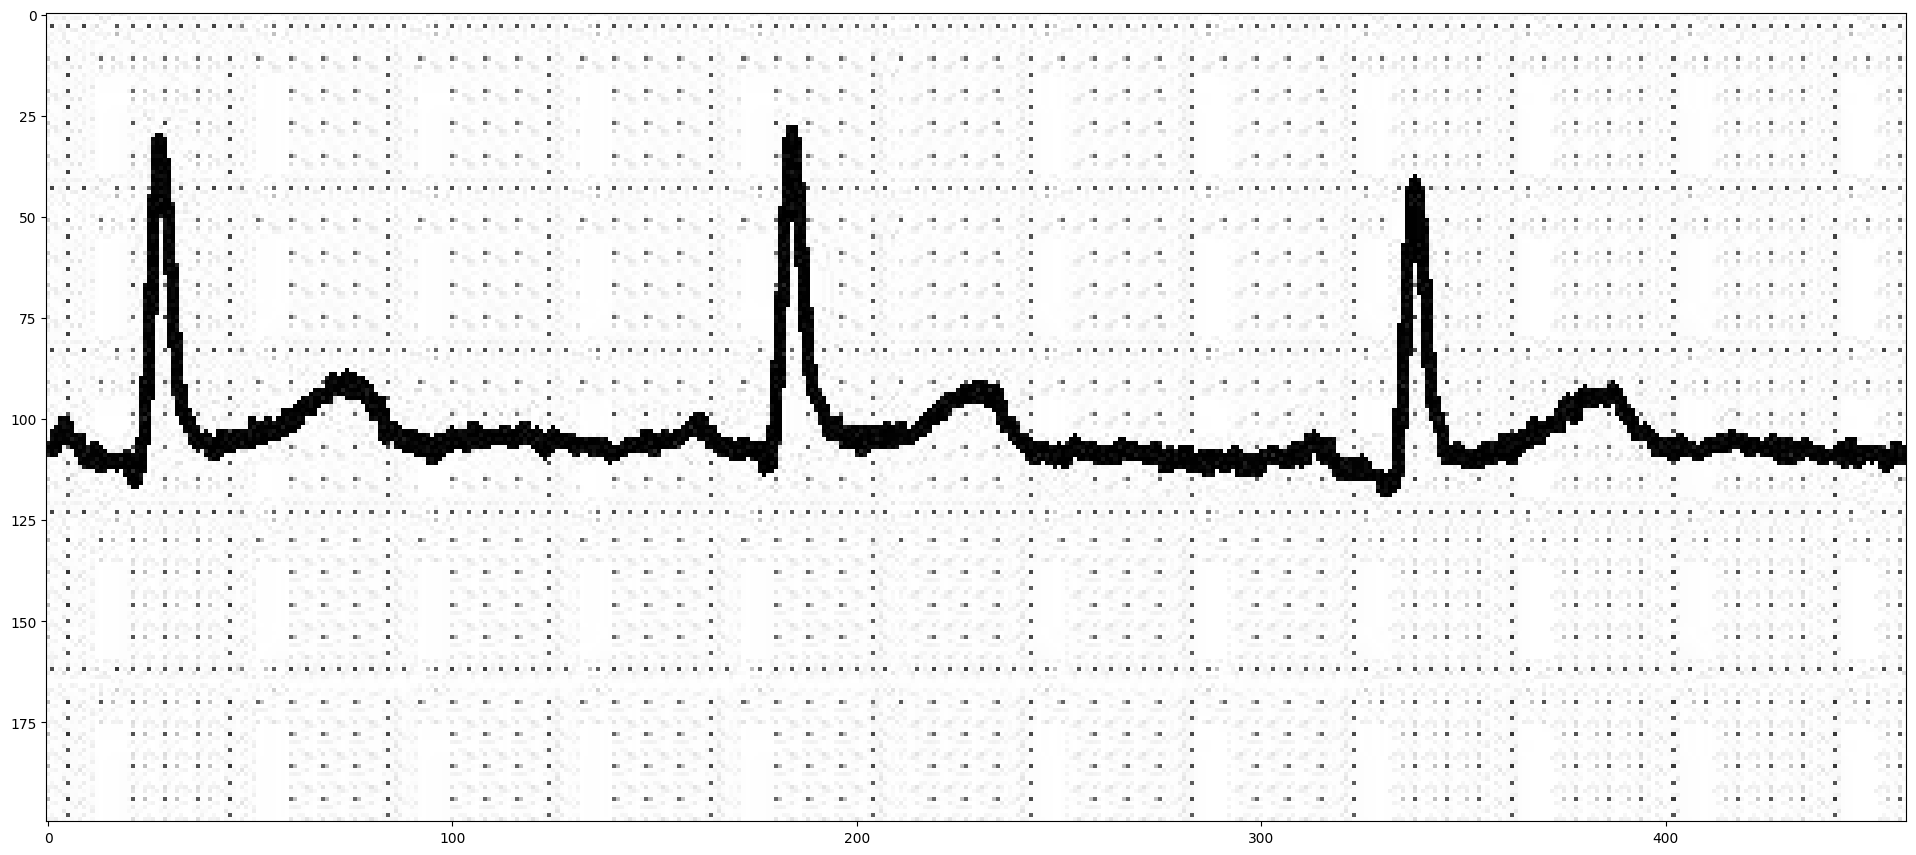

In [ ]:
# lead_I":{"ylow":360,"yhigh":560,"xlow":180,"xhigh":640,"baseline":96
plt.figure(figsize=(24,15))

plt.imshow(
cv2.cvtColor( cv2.imread("/drive/MyDrive/ECG/data_v1/NormalPersonECGImages/Normal(5).jpg")  , cv2.COLOR_BGR2GRAY)[360:560,180:640]
,cmap="gray"

)
plt.savefig("img2")